This notebook follows *The spelled-out intro to neural networks and backpropagation by Andrej Karpathy* with slight changes, comments or additions that helped me in understanding the backpropagation better.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

### Evaluating function gradient numerically

In [2]:
def func(x):
    return x**2

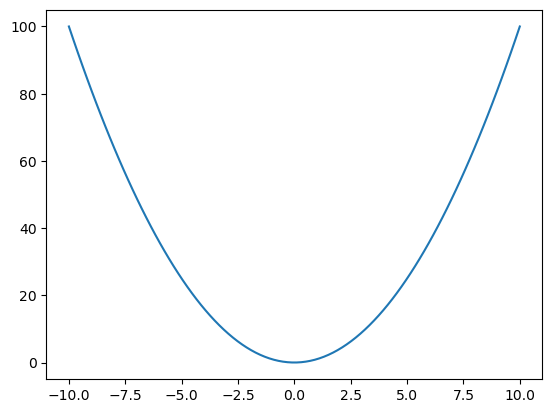

In [3]:
plt.plot(np.linspace(-10, 10, 100), func(np.linspace(-10, 10, 100)))

Calculating gradients analitically is problematic as with growing number of the networks layers the derivative would've been massive. That is why the gradient is calculated with the definition of derivative and numerical approximation.

In [4]:
def approx_derivative(f, x, eps=1e-5):
    return (f(x + eps) - f(x)) / eps

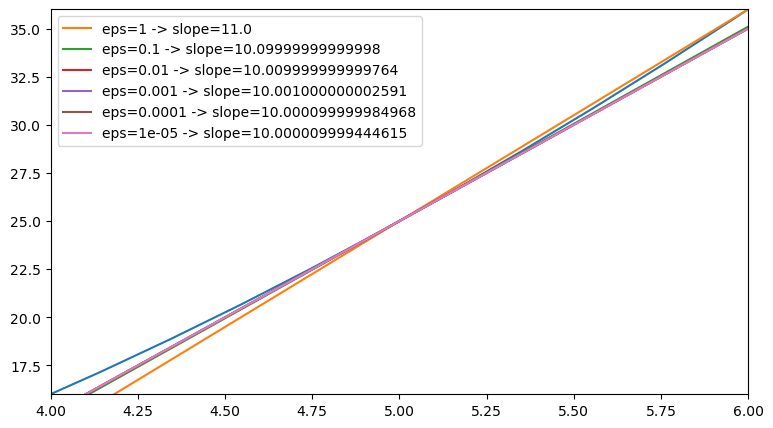

In [5]:
def get_b(slope, x, f):
    return f(x) - slope * x

plt.figure(figsize=(9, 5))
plt.plot(np.linspace(-10, 10, 100), func(np.linspace(-10, 10, 100)))
for eps in [1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
    slope = approx_derivative(func, 5, eps)
    plt.plot(np.linspace(-10, 10, 100), slope * np.linspace(-10, 10, 100) + get_b(slope, 5, func), label=f"eps={eps} -> slope={slope}")

plt.xlim(4, 6)
plt.ylim(func(4), func(6))
plt.legend()

Just like the formal definition states: we approach the derivative bringing the epsilon towards 0. Gotta be careful with the magnitude of epsilon as too many zeros will result in a floating point error and give an incorrect result.

We can also compare the results to the analitical solution. The derivative of $x^2$ is $2x$ so $f'(5)=2*5=10$, we are pretty close.

### But how does this translate to NNs?

In [6]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Values(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
    
Value(6), Value(6) + Value(10), Value(6) * Value(10)

(Values(data=6), Values(data=16), Values(data=60))

Using the code provided in **The spelled out intro to neural networks [...]** we can plot the graphs of the Value class.

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [8]:
a, b = Value(6, label="a"), Value(-10, label="b")
c = a * b 
c.label = "c"
d = Value(-10, label="d")
e = c + d
e.label = "e"

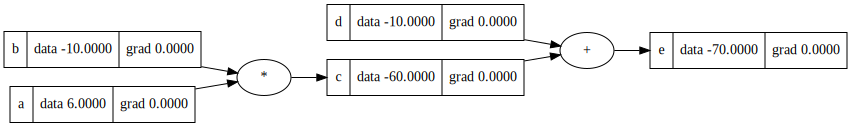

In [9]:
draw_dot(e)

At each data node the gradient has to be calculated with respect to the final data node, in this case we would like each grad to be of form: $\frac{\partial e}{\partial x}$.

Calculating 

$\frac{\partial e}{\partial e}=1$ 

is easy as it follows the basic definition of a derivative. Going back one more step the derivatives we can use the same method:

$\frac{\partial e}{\partial c}=\frac{\partial (c + d)}{\partial c}=1$ 

For further levels we have to use the chain rule:

$\frac{\partial e}{\partial b}=\frac{\partial e}{\partial c} \cdot \frac{\partial c}{\partial b} = d \cdot \frac{\partial (a+b)}{\partial b} = 1 \cdot a = a$ 

Duh.

We can check each $\frac{\partial e}{\partial x}$ below, by changing the place of $h$ addition.

In [10]:
def check_derivative():
    h = 0.001

    c = Value(6, label="a") * Value(-10, label="b")
    c.label = "c"
    e = c + Value(-10, label="d")
    e.label = "e"
    e1 = e.data

    c = Value(6 + h, label="a") * Value(-10, label="b")
    c.label = "c"
    e = c + Value(-10, label="d")
    e.label = "e"
    e2 = e.data

    return (e2 - e1) / h

check_derivative()

-10.000000000005116

We can now manually update all the gradients and check the graph again:

In [11]:
a.grad = -10
b.grad = 6
c.grad = 1
d.grad = 1 
e.grad = 1

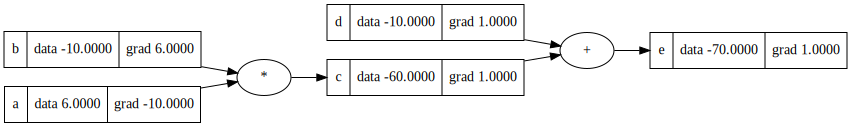

In [12]:
draw_dot(e)

Gradient literally means to "step", so applying this logic if we add some small value to each node then $e$ should be slightly greater. We will add only to the leaf (no children) nodes, as these are the ones we usually have control over.

In [13]:
a.data += 0.001 * a.grad
b.data += 0.001 * b.grad
d.data += 0.001 * d.grad

c = a * b
e = c + d
e

Values(data=-69.86306)

Great success.

### Backpropagating through an example

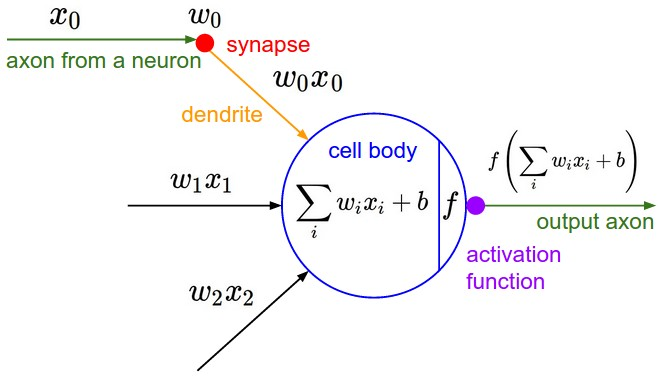

Having built and seen previous examples we can now visualize how some easy two input artificial neuron can be implemented.

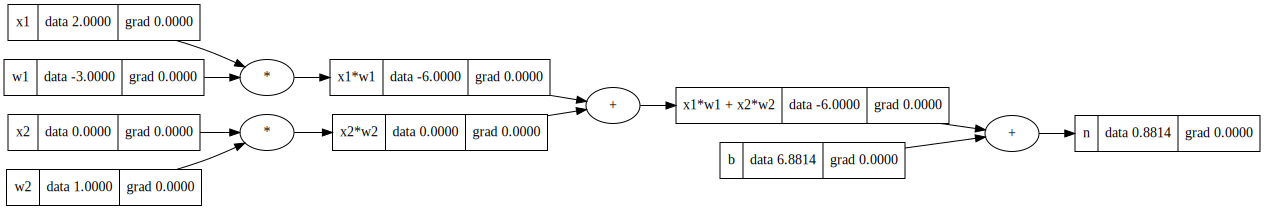

In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
draw_dot(n)

To add the tanh activation function that will squash the output of "cell body" (last summation) part, we have to either add the $e^x$ and build tanh out of it or just implement tanh as a method of the class. 

In [15]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Values(data={self.data})"

    def __add__(self, other):
        return Value(self.data + other.data, (self, other), "+")

    def __mul__(self, other):
        return Value(self.data * other.data, (self, other), "*")
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2**x) - 1) / (math.exp(2**x) + 1)
        return Value(tanh, (self, ), "tanh")

Lets check how the whole neuron computation graph looks:

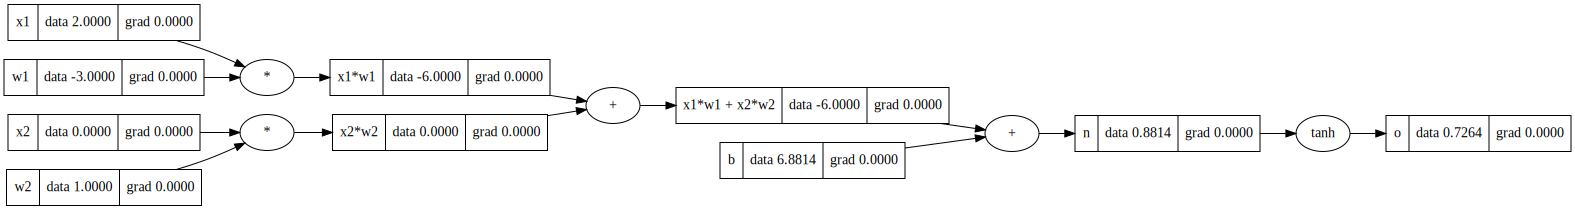

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)

#### Adding node-to-node backward gradient propagation

Now we should come up with a way with automating the gradient calculations instead of filling it manually everytime. To each manipulation like addition, multiplication, activation function etc. we have to add a backward function that will define how this transformation of Value will work with gradient propagation. 

These functions while performing the manipulations will set pointers to attributes of all objects so that later, when this function is called the values self, and other grads can be set when the out gradient is finally known - after whole forward pass. 

In [46]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Values(data={self.data})"

    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad = 1 * out.grad
            other.grad = 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2**x) - 1) / (math.exp(2**x) + 1)
        out = Value(tanh, (self, ), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad

        out._backward = _backward
        return out

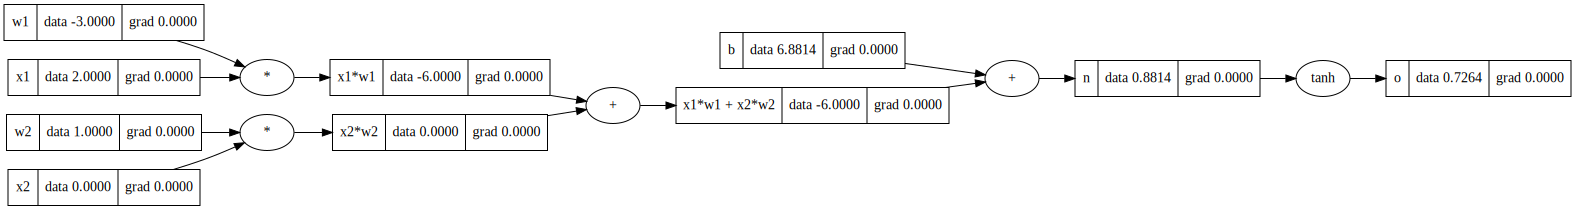

In [47]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)

#### Manual check of single backward gradient propagations

Last gradient has to be manually initialized, otherwise it would be 0 as, from the chain rull, gradient value is always multiplied with upstream grad, here there is none so we have to set it. 

Explicitly in `o._backward()` we call:

```
            self.grad = (1 - tanh**2) * out.grad
```
and `out.grad=0` from the `Value` class initialization.

In [50]:
o.grad = 1
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

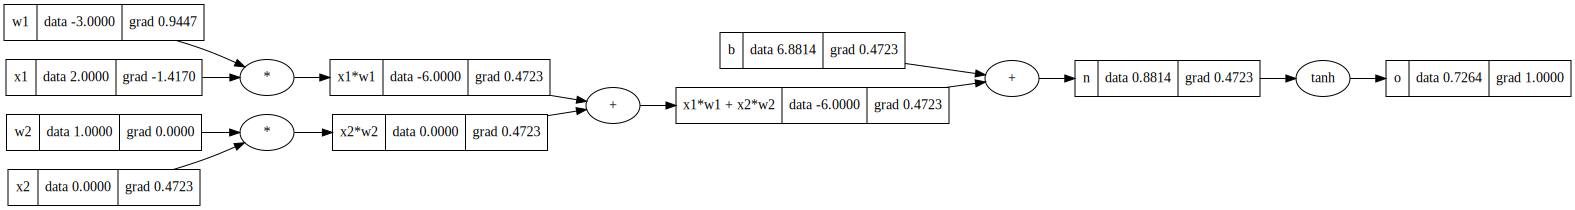

In [51]:
draw_dot(o)

Leaf nodes `_backward()` is just `lambda: None` so nothing happens. Rest worked fine, even though it looks strange, we got the tanh derivative and then it is just propagated until the multiplication, where the gradients change.

#### Creating a directed acyclic graph (chronologicaly ordering it all)

We have built the backward pass tools and now we have to make them work automatically. For this we can build a directed graph pointing from the last to first eleements. For that we can use a recurrent function that will check each children of the Value we give it, and check the children of its children etc. until it comes to the beginning. 

In [52]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Values(data=2.0),
 Values(data=-3.0),
 Values(data=-6.0),
 Values(data=0.0),
 Values(data=1.0),
 Values(data=0.0),
 Values(data=-6.0),
 Values(data=6.881373587019543),
 Values(data=0.8813735870195432),
 Values(data=0.7264004592324927)]

We rock. Lets complete it. 

Start with zeroing everything again.

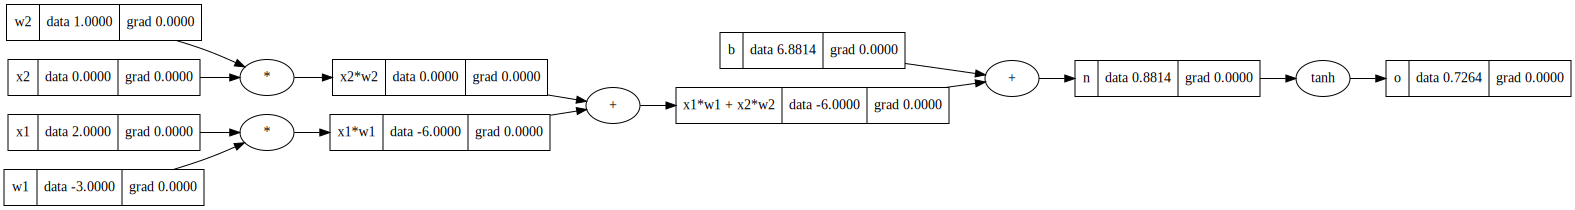

In [53]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)

All the steps of automatic gradient pass are right there.

1. Set the starting gradient manually. 
2. Build the graph (JUST PUT THE VALUE NODES IN ORDER)
3. Reverse it so the list starts with last node and call `_backward()` on all

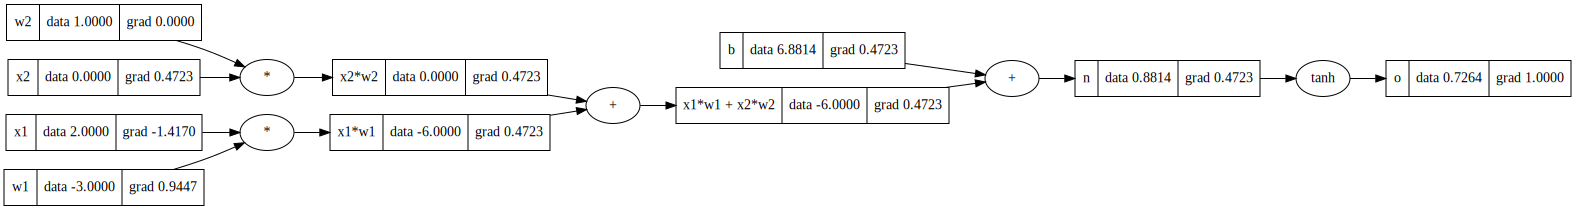

In [54]:
o.grad = 1

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

draw_dot(o)

Literally magic.

#### Adding the DAG creation and whole backprop to the Value class

Lets just make it look pretty now and add the whole backward pass as a method to the Value class so you can call it anywhere you want.

In [60]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Values(data={self.data})"

    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad = 1 * out.grad
            other.grad = 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2**x) - 1) / (math.exp(2**x) + 1)
        out = Value(tanh, (self, ), "tanh")

        def _backward():
            self.grad = (1 - tanh**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self): # adding method for whole backward pass 
        self.grad = 1

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return topo
        topo = build_topo(self)

        for node in reversed(topo):
            node._backward()

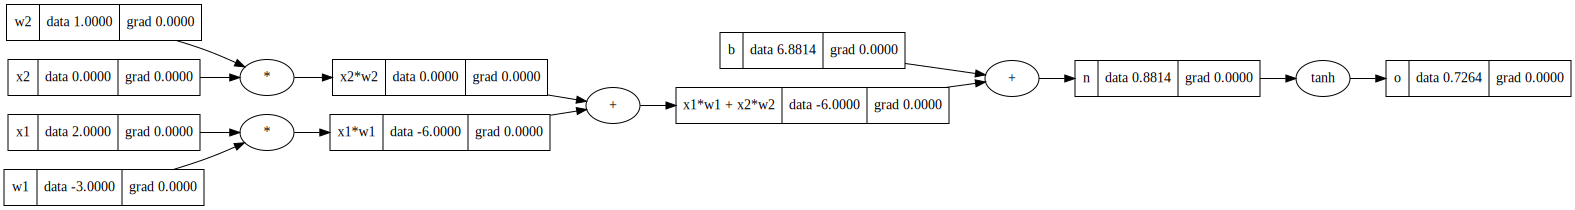

In [61]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = "o"
draw_dot(o)

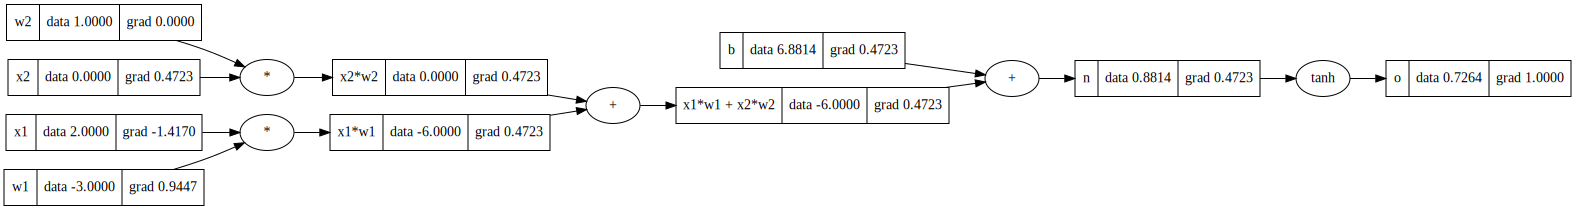

In [62]:
o.backward()
draw_dot(o)

Ooof.

#### Hold your horses, there is a bug...

We can create an operation in which we use the same node twice, in this situation `self` and `other` become the same and we are just overwriting the gradient instead of setting two of them.

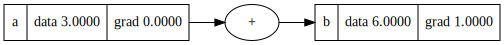

In [63]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

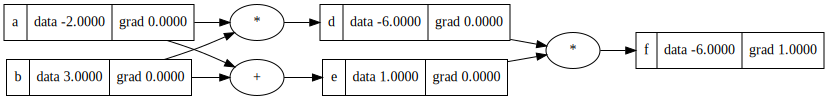

In [64]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)

From multivariable calculus: those gradients should accumulate.

In [93]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Values(data={self.data})"

    def __add__(self, other):
        out =  Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1 * out.grad # adding += for each gradient def
            other.grad += 1 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2**x) - 1) / (math.exp(2**x) + 1)
        out = Value(tanh, (self, ), "tanh")

        def _backward():
            self.grad += (1 - tanh**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return topo
        topo = build_topo(self)

        for node in reversed(topo):
            node._backward()

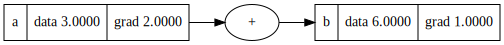

In [94]:
a = Value(3.0, label='a')
b = a + a
b.label = 'b'
topo = b.backward()
draw_dot(b)

Defining behaviour between `Value` and other numbers. Adding the exponens method and its single-backward. Adding division as negative power.

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
        self.grad = 0

    def __repr__(self) -> str:
        return f"Values(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other) # initiate Value object if other is not Value
        out =  Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1 * out.grad

        out._backward = _backward
        return out
    
    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other) # initiate Value object if other is not Value
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out
    
    def __rmull__(self, other): # when number * Value this is a fallback procedure, Python calls the method of first object in the operation so it would call number.__mul__() and then it would do Value.__rmull__() 
        return self * other # calls Value.__mul__()
    
    def __truediv__(self, other):
        return self * other**(-1)
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float"
        out = Value(self.data**other, (self, ), f"**{other}")

        
    
    def exp(self): # adding the exponens function to Value class
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.grad * math.exp(x)

        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        tanh = (math.exp(2**x) - 1) / (math.exp(2**x) + 1)
        out = Value(tanh, (self, ), "tanh")

        def _backward():
            self.grad += (1 - tanh**2) * out.grad

        out._backward = _backward
        return out
    
    def backward(self):
        self.grad = 1

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
            return topo
        topo = build_topo(self)

        for node in reversed(topo):
            node._backward()